In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import pandas as pd
import glob
from scipy.stats import poisson
from scipy.stats import multivariate_normal
import pyccl as ccl
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import abundance as cl_count
import covariance as covar
import lnlikelihood
import mvp_pdf
import edit

In [2]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

# Prediction

In [3]:
n_z_bin = 80
n_logm_bin = 30
z_corner = np.linspace(0.2, 1.2, n_z_bin + 1)
logm_corner = np.linspace(14.2, 15.6, n_logm_bin + 1)
Z_bin, logMass_bin = binning(z_corner), binning(logm_corner)

# Theoretical prediction

In [4]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
Sij = clc.sky_area/(4*np.pi)
z_grid = np.linspace(0., 2.1, 2000)
logm_grid = np.linspace(14.1, 15.7, 2001)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = logm_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

In [5]:
Covariance = covar.Covariance_matrix()
#use PySSC from Lacasa et al.
Sij = Covariance.matter_fluctuation_amplitude_fullsky(Z_bin)

In [6]:
Sij

array([[ 6.80052878e-05,  1.89970124e-05, -8.79450452e-07, ...,
         4.79599770e-10, -1.59705260e-08,  5.29311487e-09],
       [ 1.89970124e-05,  5.82544019e-05,  1.70146310e-05, ...,
         1.27628693e-08, -2.06516118e-08,  2.60710071e-09],
       [-8.79450452e-07,  1.70146310e-05,  5.35429579e-05, ...,
         6.23924997e-10, -9.98526032e-09, -4.24557177e-09],
       ...,
       [ 4.79599770e-10,  1.27628693e-08,  6.23924997e-10, ...,
         1.75330600e-06,  8.19413545e-07,  2.83036534e-07],
       [-1.59705260e-08, -2.06516118e-08, -9.98526032e-09, ...,
         8.19413545e-07,  1.76898188e-06,  8.43642479e-07],
       [ 5.29311487e-09,  2.60710071e-09, -4.24557177e-09, ...,
         2.83036534e-07,  8.43642479e-07,  1.68908972e-06]])

In [7]:
Sample_covariance = Covariance.sample_covariance_full_sky(Z_bin, logMass_bin,  NHalo_bias, Sij)/0.25

top


In [8]:
Covariance_prediction = Sample_covariance + np.diag(Abundance.flatten())

In [9]:
indexz = 3
indexm = 3

In [10]:
Abundance[indexm,indexz]

85.87285047588516

In [11]:
mu_list = Abundance.flatten()
var_SSC_list = Sample_covariance.diagonal()
MVP = mvp_pdf.MVP(mu_list, var_SSC_list)
MVP._set_axis(5, mu_list, var_SSC_list)
N_, P_MVP = MVP.p_mvp(mu_list, var_SSC_list)

/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/mvp_pdf.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  P_MVP = np.array([P_MVP_table[indexes] for indexes in self.split_indexes])


In [12]:
mu_list_order = np.sort(mu_list)

In [13]:
mu_list_order

array([2.80893998e-06, 3.39422664e-06, 4.09553100e-06, ...,
       3.18553878e+02, 3.18666298e+02, 3.18778608e+02])

# likelihood

In [14]:
lnL = lnlikelihood.lnLikelihood()

[0.0038517732550693144, 0.015886746667915886, 318.7786075690562]


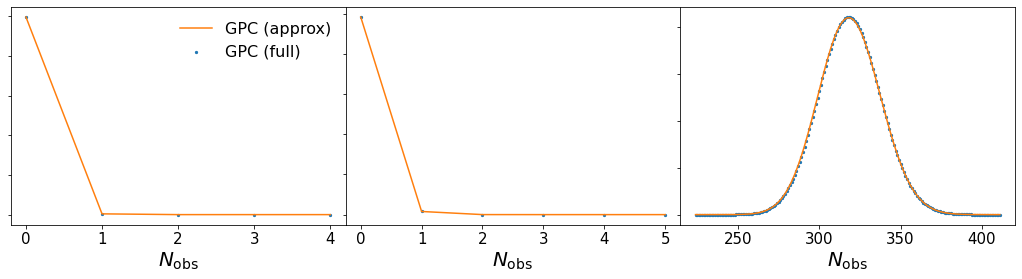

In [15]:
k = 0
intervals = [[1,2],[50, 60],[1200,2000]]
mu_list_plot = [mu_list_order[190], mu_list_order[300], mu_list_order[-1]]
print(mu_list_plot)
interval_done = [False, False, False]
bins = [np.arange(10)-.5, np.linspace(1,500,100), np.linspace(intervals[2][0],intervals[2][1],70)]
fig, ax = plt.subplots(1, 3, figsize = (18,4))
plt.subplots_adjust(wspace = .0)
plt.rcParams['axes.axisbelow'] = True
for n, p_mvp, i in zip(N_, P_MVP, np.arange(len(N_))):
    mu = mu_list[i]
    rv = poisson(mu)
    n_sigma = 5
    mask = (n > mu - n_sigma*np.sqrt((var_SSC_list[i] + mu)))*(n < mu + n_sigma*np.sqrt((var_SSC_list[i] + mu)))
    poisson_ = rv.pmf(n)
    pdf = multivariate_normal.pdf(n, mean=mu, cov=var_SSC_list[i] + mu)
    for s, interval in enumerate(intervals):
        if (mu == mu_list_plot[s])*(interval_done[s] == False):
            interval_done[s] = True
            #ax[s].plot(n[mask], poisson_[mask], '-k', linewidth = 3, label = 'Poissonian')
            #ax[s].plot(n[mask], pdf[mask]/np.sum(pdf), '-g', linewidth = 3, label = 'Gaussian')
            #ax[s].plot(n[mask], p_mvp[mask], '--r', linewidth = 3, label = 'MVP')
            
            #ax[s].scatter(n, poisson_, s=20,c='m', label = 'Poissonian', zorder=0)
            Takada = lnL.lnLikelihood_Binned_MPG_approx(mu, n, var_SSC_list[i], single_variate = True)
            y = poisson_ * (1 + 0.5*var_SSC_list[i]*((1-n/mu)**2 -n/(mu**2)))
            ax[s].plot(n, y/np.sum(y),color= 'tab:orange', label = 'GPC (approx)')
            
            #ax[s].plot(n, pdf/np.sum(pdf), '-r', linewidth = 4, label = 'Gaussian')
            ax[s].scatter(n, p_mvp, s=5, label = 'GPC (full)')
            ax[s].set_xlabel(r'$N_{\rm obs}$', fontsize = 20)
            ax[s].tick_params(axis='both', which = 'major', labelsize= 15)
            if s == 0:
                ax[s].legend(frameon = False, framealpha = 1, fontsize = 16, loc = 'best')
            plt.setp( ax[s].get_yticklabels(), visible=False )
#plt.savefig('pdf_comp.pdf', bbox_inches='tight', dpi=300)